# Milestone 3: Investigate Project Questions

<hr style="clear:both">

This notebook illustrates the process we employed with the data to address the selected question from P2. Please feel free to refer to our external script for insights into certain steps involved in enriching, retrieving, and processing data. We utilized multiple APIs in this process, though they are not explicitly detailed here due to their relative complexity and their lack of relevance to P3.

**Project Mentor:** [Aoxiang Fan](https://people.epfl.ch/aoxiang.fan) ([Email](mailto:aoxiang.fan@epfl.ch))
**Authors:** [Luca Carroz](https://people.epfl.ch/emilie.carroz), [David Schroeter](https://people.epfl.ch/david.schroeter), [Xavier Ogay](https://people.epfl.ch/xavier.ogay), [Joris Monnet](https://people.epfl.ch/joris.monnet), [Paulo Ribeiro de Carvalho](https://people.epfl.ch/paulo.ribeirodecarvalho)

<hr style="clear:both">

## Import

In [1]:
# Import needed libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
import warnings
from question_script.question_helper import extract_composers_dataframe

# Load autoreload extension
%load_ext autoreload
%autoreload 2

## Load Data

Section to load data. Check that all datasets are already computed or downloaded, if not please read `README.md` and follow steps for its creation.

In [2]:
# Write your path to all the dataset we need to load
datasets_path = 'dataset'

# Load data
spotify_composers_dataset = pd.read_pickle(os.path.join(datasets_path, 'spotify_composers_dataset.pickle'))
clean_enrich_movies = pd.read_pickle(os.path.join(datasets_path, 'clean_enrich_movies.pickle'))
location_to_country = pd.read_csv(os.path.join(datasets_path, 'mapping_locations_to_country.csv'))

## Question 1

Which are the most frequent music genre appearing in movies ?



In [4]:
from question_script.question1 import question_1

# Create dataframe to map composers to movies
map_composers_to_movies = extract_composers_dataframe(clean_enrich_movies)[['name', 'c_name', 'box_office_revenue']]

# Rename columns names to avoid unclear merging
map_composers_to_movies.columns = ['m_name', 'c_name', 'box_office_revenue']

# Merge movies to spotify dataframe and select wanted attributes
movie_music_genre_df = pd.merge(left=spotify_composers_dataset,
                                right=map_composers_to_movies,
                                left_on='name',
                                right_on='c_name',
                                how='inner')#[['name', 'genres', 'box_office_revenue']]

# Display results for first question
question_1(movie_music_genre_df=movie_music_genre_df,
           min_revenue=0,
           max_revenue=int(1e12),
           soundtrack_in_genre=True)

genre  count
2               soundtrack   2725
18   orchestral soundtrack   1545
12      classic soundtrack   1321
21      british soundtrack    597
3        french soundtrack    255
..                     ...    ...
48                   ye ye      1
358        irish classical      1
357            celtic harp      1
356          women's music      1
618          serbian indie      1

[619 rows x 2 columns]

## Question 2

What is the average composer's age at their :
   - first movie appearance ?
   - biggest box office revenue ?

### Average composer's age at their first movie appearance

In [81]:
from question_script.question2 import *

composer_dataframe_with_fst_appearance = calculate_composer_age_fst_appearance(clean_enrich_movies)

composer_fst_appearance_days, composer_fst_appearance_years = get_average_age_first_appearance(
    composer_dataframe_with_fst_appearance)

print("The average age of the composer at his first movie is:\n"
      f"\t- {composer_fst_appearance_years:.3f} years\n"
      f"\t- {composer_fst_appearance_days:.3f} days")

The average age of the composer at his first movie is:
	- 34.198 years
	- 12490.663 days


C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



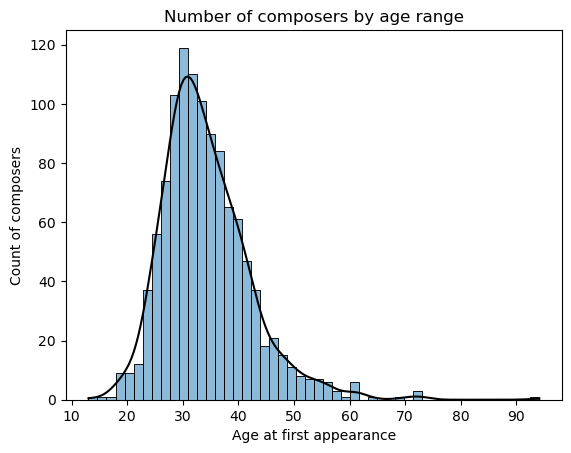

In [82]:
plot_composer_by_age_range(composer_dataframe_with_fst_appearance, 'c_age_first_appearance_years', bin_nb=50)

### Average composer's age at their biggest box office revenue

In [83]:
composer_age_highest_box_office = calculate_composer_age_highest_box_office(clean_enrich_movies)

composer_age_high_box_office_days, composer_age_high_box_office_years = get_average_age_high_box_office(
    composer_age_highest_box_office)

print("The average age of the composer at his highest box office revenue is:\n"
      f"\t- {composer_age_high_box_office_years:.3f} years\n"
      f"\t- {composer_age_high_box_office_days:.3f} days")

The average age of the composer at his highest box office revenue is:
	- 41.891 years
	- 15300.559 days


C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



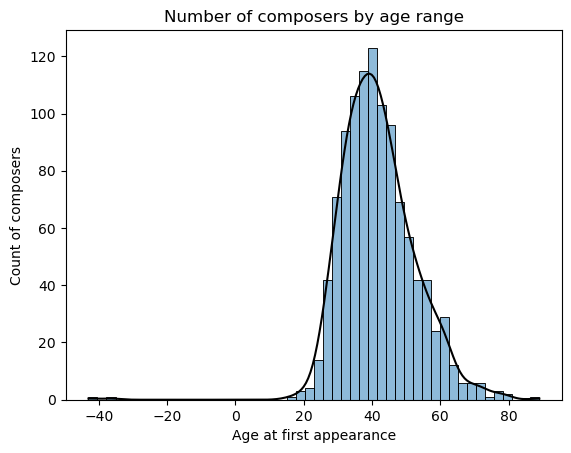

In [84]:
plot_composer_by_age_range(composer_age_highest_box_office, 'c_age_highest_revenue_years', bin_nb=50)

## Question 3

How the top composers' career progress over the years ?

In [11]:
from question_script.question3 import *

movie_renamed = prepare_data_for_q3()

display(movie_renamed.head())

release_year  composer_id      composer_name  box_office_revenue
0         2009         1729       James Horner        2.782275e+09
1         1997         1729       James Horner        2.185372e+09
2         2012           37     Alan Silvestri        1.511758e+09
3         2011         2949  Alexandre Desplat        1.328111e+09
4         2013         6041        Brian Tyler        1.215577e+09

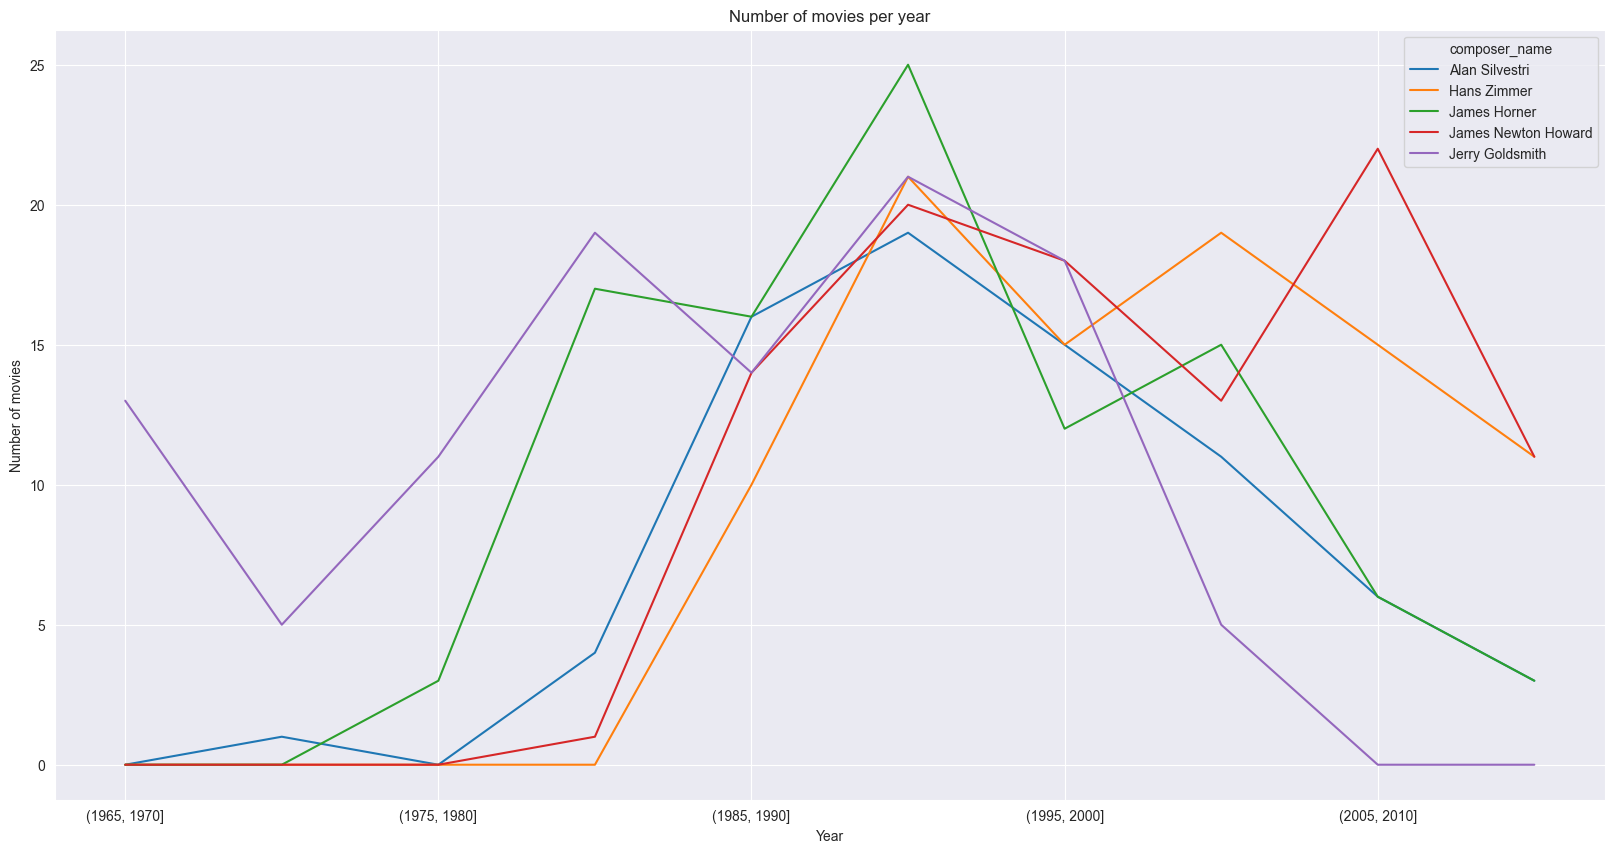

In [14]:
movie_grouped_by_top_composer = filter_by_top_composers(movie_renamed, 5)

# Change years to int
movie_grouped_by_top_composer.loc[:, 'release_year'] = movie_grouped_by_top_composer['release_year'].astype(int)

# Define bins for years
bins = np.arange(movie_grouped_by_top_composer['release_year'].min(),
                 movie_grouped_by_top_composer['release_year'].max() + 1, 5)

with warnings.catch_warnings():
    # Ignore warning about the use of cut
    warnings.filterwarnings("ignore")
    # Add a new column 'year_bin' to the DataFrame, indicating which bin each year falls into
    movie_grouped_by_top_composer['year_bin'] = pd.cut(movie_grouped_by_top_composer['release_year'], bins)

# Group by composer and year bin, count the number of movies
movie_counts = movie_grouped_by_top_composer.groupby(['composer_name', 'year_bin'], observed=False).size()

# Unstack the 'composer_name' level to create a DataFrame
movie_counts_df = movie_counts.unstack(level='composer_name')

# Plot the data
movie_counts_df.plot(kind='line', figsize=(20, 10))

# Set the title and labels
plt.title('Number of movies per year')
plt.xlabel('Year')
plt.ylabel('Number of movies')

plt.show()

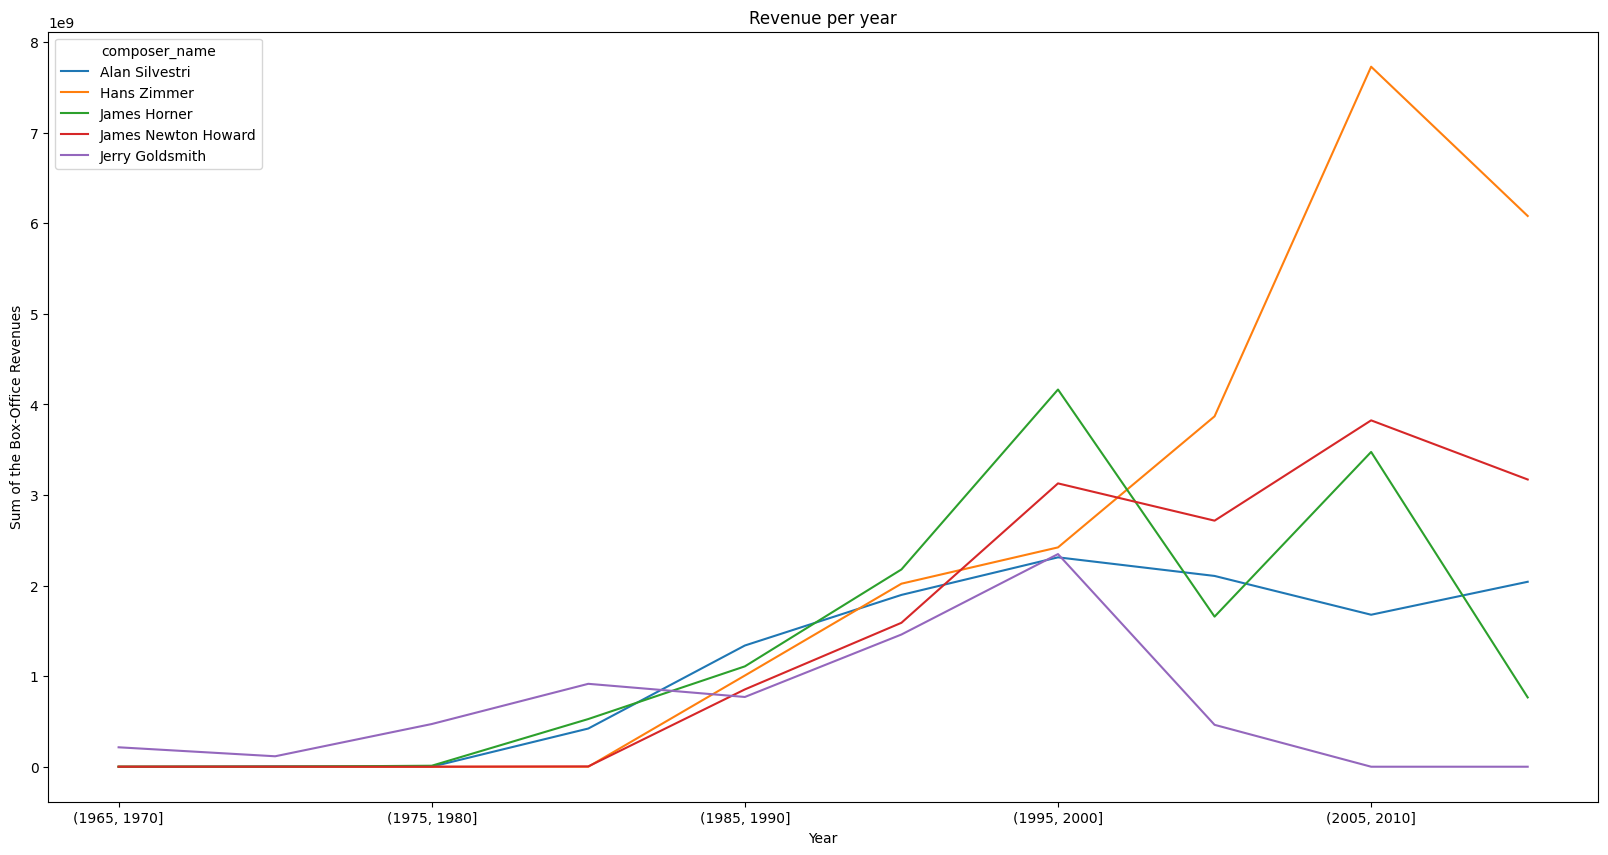

In [213]:
# Plot the evolution of the revenue for the film per year for the top composers
movie_revenue = movie_grouped_by_top_composer.groupby(['composer_name', 'year_bin'], observed=False)[
    'box_office_revenue'].sum()
movie_revenue_df = movie_revenue.unstack(level='composer_name')
movie_revenue_df.plot(kind='line', figsize=(20, 10))
plt.title('Revenue per year')
plt.xlabel('Year')
plt.ylabel('Sum of the Box-Office Revenues')
plt.show()

## Question 4

Where do composers come from ?

To answer this question, we needed to map location to countries. Indeed, we had the place of birth of our composers, but in location format (i.e. "New York City, New York, USA").

In [89]:
from question_script.question4 import *

# Use the already computed dataframe from q.1 to retrieve information like the place_of_birth of all composers
composer_place_of_birth_df = pd.merge(
    left=spotify_composers_dataset,
    right=composers_to_movies,
    left_on='name',
    right_on='composer_name',
    how='inner'
)[['composer_name', 'composer_place_of_birth', 'popularity']].drop_duplicates()  # note: few rows were duplicate

# Delete rows (composers) where we do not have the place of birth (i.e. None value)
composer_place_of_birth_df = composer_place_of_birth_df.query('composer_place_of_birth.notna()')

# Compute the number of composer per location within the selected range of composer's popularity
number_composer_per_location = composers_selection_over_popularity(
    df=composer_place_of_birth_df,
    min_popularity=0,
    max_popularity=100
).groupby('composer_place_of_birth').count()["composer_name"]

# For plot reasons, map all locations to its corresponding country and count again the number of composer
number_composer_per_country = pd.merge(
    left=number_composer_per_location,
    right=location_to_country,
    left_on='composer_place_of_birth',
    right_on='location',
    how='outer'
).groupby('country').count()["location"]

[link](https://plotly.com/python/builtin-colorscales/) to see different colors.

In [90]:
heat_map_world(df=number_composer_per_country.reset_index(),
               color='peach')

## Question 5

Does composer's gender matter ?

In [9]:
#TODO: uncomment and delete plotly code 
#from question_script.question5 import *
#
## Get all movie composers
#composers = get_cleaned_composers()
#
## Count the occurrences of each gender
#gender_counts = composers['gender'].value_counts()
#
## Create a bar chart
#fig, ax = plt.subplots()
#bars = ax.bar(gender_counts.index, gender_counts)
#
## Set plot title and labels
#ax.set_title("Number of Male vs Female movie composers from 1915 to 2014")
#ax.set_xlabel("Gender")
#ax.set_ylabel("Count")
#
## Add hover information as text labels above the bars
#for bar in bars:
#    yval = bar.get_height()
#    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f'Count: {yval}', ha='center', va='bottom')
#
## Show the plot
#plt.show()
# TODO: this plot is not very interesting for the website, only add the one with the years (below)
from question_script.question5 import *

# Get all movie composers
composers = get_cleaned_composers()

# Count the occurrences of each gender
gender_counts = composers['gender'].value_counts()

# Create a bar chart with hover information
fig = px.bar(x=gender_counts.index, y=gender_counts,
             title="Number of Male vs Female movie composers from 1915 to 2014",
             labels={'y': 'Count', 'x': 'Gender'})

# Add hover information
fig.update_traces(hovertemplate='Count: %{y}')

# Show the plot
fig.show()

Let's see how this ratio evolved over the years

In [115]:
## Dataframe containing the number of composers for each year, grouped by their gender
#gender_prop_by_year = pd.crosstab(index=composers['release_date'], columns=composers['gender'], normalize='index')
## Plot the dataframe
#gender_prop_by_year.plot(kind='bar', stacked=True, color=['red', 'blue'], figsize=(20, 10))
#plt.xticks(np.arange(-2, 96, 10))
#plt.title('Proportion of Female vs Male composers across years')
#plt.legend(loc="upper left", ncol=2)
#plt.xlabel("Year")
#plt.ylabel("Proportion")
#plt.show()

# Get all movie composers
composers = get_cleaned_composers()

# Dataframe containing the number of composers for each year, grouped by their gender
gender_prop_by_year = pd.crosstab(index=composers['release_date'], columns=composers['gender'], normalize='index')

# Reshape the dataframe to long format
gender_prop_by_year = gender_prop_by_year.reset_index().melt(id_vars=['release_date'], var_name='gender',
                                                             value_name='proportion')

# Create a bar chart with hover information
fig = px.bar(gender_prop_by_year,
             x='release_date',
             y='proportion',
             color='gender',
             title='Distribution of female vs male composers across years',
             labels={'proportion': 'Percentage', 'gender': 'Gender', 'release_date': 'Year'},
             hover_data={'proportion': ':.1%'},
             log_y=True,
             color_discrete_map={'Female': 'rgba(180, 151, 231, 0.8)', 'Male': 'rgba(136, 136, 136, 0.2)'},
             width=800,
             height=400)

# Change x axis ticks to be more readable
fig.update_layout(xaxis=dict(tickmode='linear', tick0=-2, dtick=10),
                  yaxis=dict(tickformat=',.0%'),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.write_html("question_script/question5.html")
# Show the plot
fig.show()

## Question 6

Does having a personal website correlate with the composers' success ?

In [116]:
from question_script.question6 import *

#composers_success_website = get_composer_success_and_website()
#composers_success_website.boxplot(column='popularity', by='has_homepage', figsize=(20, 10))

composers_success_website = get_composer_success_and_website()
fig = px.box(composers_success_website,
             x="website",
             y="total_box_office",
             log_y=True,
             notched=True,
             labels={'website': '', 'total_box_office': 'Total box office revenue'},
             points="all",
             hover_data={'website': False},
             boxmode="overlay",
             title="Popularity of composers with and without a personal website")
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.write_html("question_script/question6.html")
fig.show()

In [77]:
# Perform Pearson correlation test
correlation_coefficient, p_value = pearsonr(composers_success_website['total_box_office'],
                                            composers_success_website['has_website'])

# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a significant correlation.")
    if correlation_coefficient > 0:
        print("The correlation is positive.")
    elif correlation_coefficient < 0:
        print("The correlation is negative.")
    else:
        print("There is no linear correlation, but there may be a non-linear relationship.")
else:
    print("There is no significant correlation.")

Pearson correlation coefficient: 0.11253512834674324
P-value: 2.3663783597549656e-08
There is a significant correlation.
The correlation is positive.


## Question 7

Is there a correlation between box office revenue and movie's playlist popularity ?

In [116]:
import question_script.question7 as q7

merged_df, pop_df = q7.get_merged_and_pop_df()

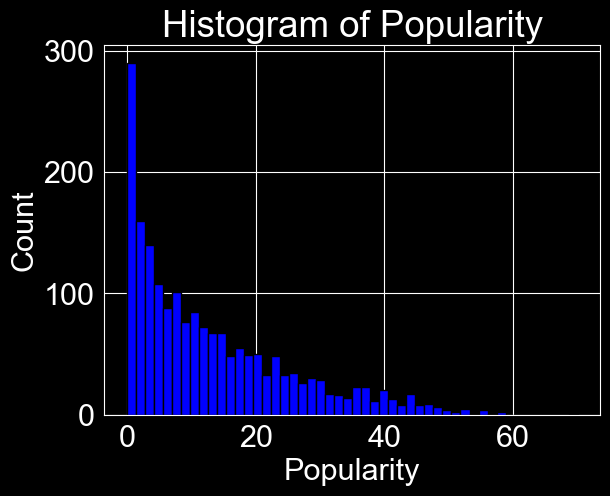

In [117]:
q7.plot_popularity_histogram(pop_df)
q7.plot_popularity_histogram_matplt(pop_df)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

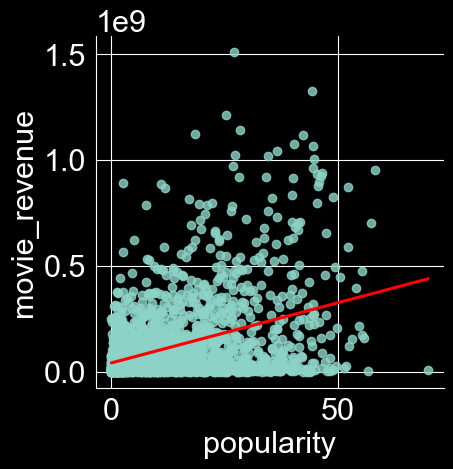

In [118]:
q7.plot_scatter_popularity_revenue_overall(merged_df)
q7.plot_scatter_popularity_revenue_overall_matplotlib(merged_df)

In [119]:
q7.print_pearson_correlation(merged_df)

Pearsons correlation: 0.392


C:\Users\xagao\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning:

divide by zero encountered in scalar divide



C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



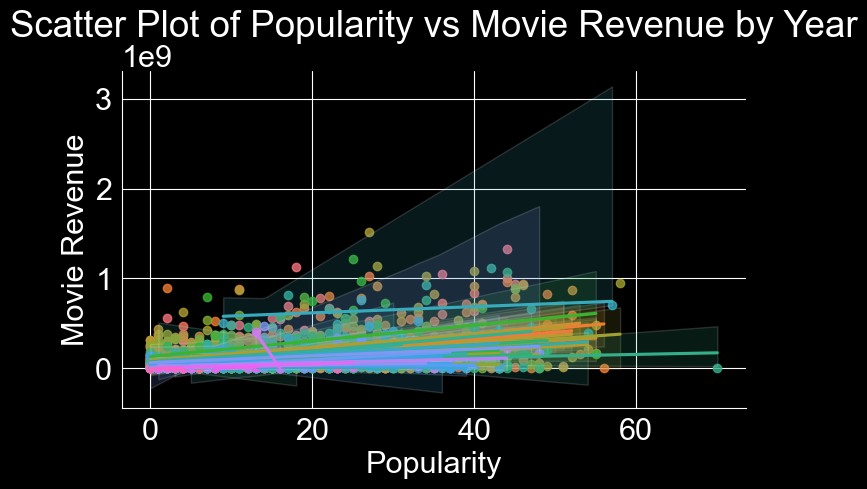

In [120]:
q7.plot_scatter_popularity_revenue_by_year(merged_df)
q7.plot_scatter_popularity_revenue_by_year_matplotlib(merged_df)

year  correlation      mean_revenue
15  1959     0.477916        7319548.25
17  1961     0.205819        11712760.0
18  1962    -0.192297        7826090.75
19  1963     0.298659   10282764.666667
21  1965     0.520476        26147356.6
22  1966    -0.076513        14114152.0
23  1967     0.777949   27757609.909091
24  1968     0.792902        20364054.8
26  1970     0.680985        39887726.8
27  1971    -0.470170   29420784.333333
28  1972     0.718369   47244851.181818
29  1973     0.228465         9490034.5
30  1974    -0.468728   60333593.142857
31  1975     0.353226       116081837.5
32  1976     0.485535      59980968.625
33  1977     0.645318  138039571.333333
34  1978     0.689442   97891851.285714
35  1979     0.515015   82256671.833333
36  1980    -0.094767   35433324.333333
37  1981     0.727236   20786563.166667
38  1982     0.131076    102386800.6875
39  1983     0.407200   28443988.666667
40  1984     0.491480        68419219.4
41  1985     0.478945   70057933.263158
42  1986    -0.075372   52903017.826087
43  1987     0.715239       67496164.35
44  1988     0.228149   67094040.826087
45  1989     0.445257  116752972.521739
46  1990     0.479011  105745527.266667
47  1991     0.250445   75078553.805556
48  1992     0.373062   82312933.135135
49  1993     0.503204   94822283.171429
50  1994     0.503572   85010102.952381
51  1995     0.261452   81733400.576923
52  1996     0.417070  113055280.540541
53  1997     0.204026  111823255.227273
54  1998     0.250252  113434780.019608
55  1999     0.457993  133887294.592593
56  2000     0.206506   97060081.898305
57  2001     0.440173  121643870.555556
58  2002     0.473212  134144865.333333
59  2003     0.558340  139677376.942029
60  2004     0.580109  149999617.527027
61  2005     0.364741  122629587.111111
62  2006     0.414645  117068054.704082
63  2007     0.481173  135459823.446602
64  2008     0.508451  121395282.806122
65  2009     0.388706  119555247.421569
66  2010     0.500581  131471346.891304
67  2011     0.390302       150723345.0
68  2012     0.332915  188772972.534884
69  2013     0.370548  274998320.675676
70  2014     0.623022  653485808.666667

C:\Users\xagao\anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



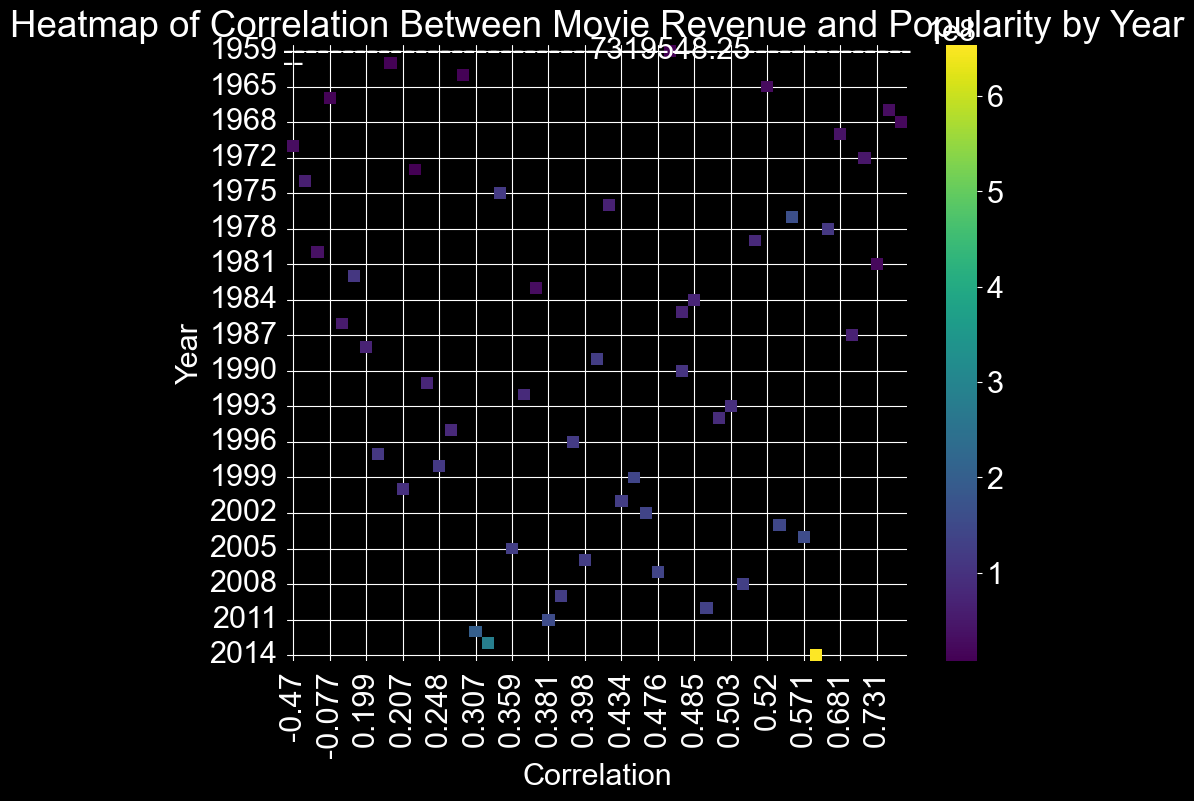

In [133]:
q7.plot_heatmap_correlation(merged_df)
q7.plot_heatmap_correlation_matplotlib(merged_df)